In [1]:
#Import essential libraries

import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers
from keras.utils import np_utils
from keras.optimizers import Adam

import pandas as pd
from google.colab import files

import gzip
import os
import sys
import struct
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import sys, time

Using TensorFlow backend.


In [0]:
# Load the Dataset

def read_image(fi):
    channel = 1
    magic, n, rows, columns = struct.unpack(">IIII", fi.read(16))
    assert magic == 0x00000803
    assert rows == 28
    assert columns == 28
    rawbuffer = fi.read()
    assert len(rawbuffer) == n * rows * columns * channel
    rawdata = np.frombuffer(rawbuffer, dtype='>u1', count=n*rows*columns*channel)
    return rawdata.reshape(n, rows, columns, channel).astype(np.float32) / 255.0

def read_label(fi):
    magic, n = struct.unpack(">II", fi.read(8))
    assert magic == 0x00000801
    rawbuffer = fi.read()
    assert len(rawbuffer) == n
    return np.frombuffer(rawbuffer, dtype='>u1', count=n)

if __name__ == '__main__':
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz')
    os.system('wget -N http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz')
    
    np.savez_compressed(
        'mnist',
        train_x=read_image(gzip.open('train-images-idx3-ubyte.gz', 'rb')),
        train_y=read_label(gzip.open('train-labels-idx1-ubyte.gz', 'rb')),
        test_x=read_image(gzip.open('t10k-images-idx3-ubyte.gz', 'rb')),
        test_y=read_label(gzip.open('t10k-labels-idx1-ubyte.gz', 'rb'))
    )

In [3]:
data = np.load('mnist.npz')

print(data['train_x'].shape, data['train_x'].dtype)
print(data['train_y'].shape, data['train_y'].dtype)
print(data['test_x'].shape, data['test_x'].dtype)
print(data['test_y'].shape, data['test_y'].dtype)

X_train = data['train_x']
y_train = data['train_y']

X_test = data['test_x']
y_test = data['test_y']

y_train = np_utils.to_categorical(y_train, 10)
y_test = np_utils.to_categorical(y_test, 10)

(60000, 28, 28, 1) float32
(60000,) uint8
(10000, 28, 28, 1) float32
(10000,) uint8


In [0]:
# Parameters for the optimized model
learning_rate = 0.000122
Number_of_Dense_Layer	= 2	
Number_of_Input_Neurons = 125	
Number_of_Neurons_Dense = 86	
Activation = 'relu'
batch_size=80	
adam_decay=0.000491

In [0]:
def create_model_optimized(learning_rate,Number_of_Input_Neurons,Number_of_Neurons_Dense,Activation,adam_decay):
  model = Sequential()
  # add Convolutional layers
  model.add(Conv2D(filters=Number_of_Input_Neurons, kernel_size=(3,3), activation=Activation, padding='same',
                     input_shape=(28,28,1)))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(filters=64, kernel_size=(3,3), activation=Activation, padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Conv2D(filters=64, kernel_size=(3,3), activation=Activation, padding='same'))
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Flatten())
  # Densely connected layers
  model.add(Dense(Number_of_Neurons_Dense,activation=Activation,name="hidden_1"))
  model.add(Dense(64,activation=Activation,name="hidden_2"))
  model.add(Dense(10,activation='softmax',name="output_layer"))
  #setup our optimizer and compile
  adam = Adam(lr=learning_rate, decay= adam_decay)
  model.compile(optimizer = adam, loss='categorical_crossentropy', metrics=["accuracy"])
  return model

In [42]:
result = create_model_optimized(learning_rate,Number_of_Input_Neurons,Number_of_Neurons_Dense,Activation,adam_decay)
result.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 28, 28, 125)       1250      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 14, 14, 125)       0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 64)        72064     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 7, 7, 64)          36928     
_________________________________________________________________
max_pooling2d_23 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 576)              

In [43]:
optimized_model = result.fit(X_train, y_train, batch_size=batch_size, epochs =4, validation_split=.15)

Train on 51000 samples, validate on 9000 samples
Epoch 1/4
51000/51000 [==============================] - 14s 268us/step - loss: 0.5536 - acc: 0.8414 - val_loss: 0.1474 - val_acc: 0.9574
Epoch 2/4
51000/51000 [==============================] - 12s 241us/step - loss: 0.1256 - acc: 0.9627 - val_loss: 0.0962 - val_acc: 0.9729
Epoch 3/4
51000/51000 [==============================] - 12s 239us/step - loss: 0.0947 - acc: 0.9717 - val_loss: 0.0842 - val_acc: 0.9766
Epoch 4/4
51000/51000 [==============================] - 12s 241us/step - loss: 0.0787 - acc: 0.9762 - val_loss: 0.0756 - val_acc: 0.9798


In [44]:
loss, accuracy = result.evaluate(X_test,y_test)
print('Accuracy = ', accuracy)
print('Loss = ', loss)

10000/10000 [==============================] - 1s 136us/step
Accuracy =  0.9803
Loss =  0.06795461275689303


In [0]:
# Predicted Labels on the optimized model
y_Predict = result.predict(X_test)
y_numeric = np.argmax(y_Predict, axis=1)
y_numeric_onehotencoded = np_utils.to_categorical(y_numeric, 10)

In [0]:
new_df = pd.DataFrame(y_numeric_onehotencoded)
new_df.to_csv('mnist_final_4.csv') 
files.download('mnist_final_4.csv')

## Training and Validation Loss for Various Activation Functions

In [0]:
def create_model_optimized(activations,batch_size):
  for active in activations:
    model = Sequential()
    # add Convolutional layers
    model.add(Conv2D(filters=125, kernel_size=(3,3), activation=active, padding='same',
                     input_shape=(28,28,1)))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation=active, padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation=active, padding='same'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    # Densely connected layers
    model.add(Dense(86,activation=active,name="hidden_1"))
    model.add(Dense(50,activation=active,name="hidden_2"))
    model.add(Dense(10,activation='softmax',name="output_layer"))
    #setup our optimizer and compile
    adam = Adam(lr=0.000122, decay= 0.000491)
    model.compile(optimizer = adam, loss='categorical_crossentropy', metrics=["accuracy"])

    optimized_model = result.fit(X_train, y_train, batch_size=batch_size, epochs =15, validation_split=.15)
    show_plots(optimized_model.history)
  return model

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
import sys, time

def show_plots(history):
    """ Useful function to view plot of loss values & accuracies across the various epochs """
    loss_vals = history['loss']
    val_loss_vals = history['val_loss']
    epochs = range(1, len(history['acc'])+1)
    
    f, ax = plt.subplots(nrows=1,ncols=2,figsize=(16,4))
    
    # plot losses on ax[0]
    ax[0].plot(epochs, loss_vals, color='navy',marker='o', label='Training Loss')
    ax[0].plot(epochs, val_loss_vals, color='firebrick', marker='*', label='Validation Loss')
    ax[0].set_title('Training & Validation Loss')
    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend(loc='best')
    ax[0].grid(True)
    
    # plot accuracies
    acc_vals = history['acc']
    val_acc_vals = history['val_acc']

    ax[1].plot(epochs, acc_vals, color='navy', marker='o', label='Training Accuracy')
    ax[1].plot(epochs, val_acc_vals, color='firebrick', marker='*', label='Validation Accuracy')
    ax[1].set_title('Training & Validation Accuracy')
    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Accuracy')
    ax[1].legend(loc='best')
    ax[1].grid(True)
    
    plt.show()
    plt.close()
    
    # delete locals from heap before exiting
    del loss_vals, val_loss_vals, epochs, acc_vals, val_acc_vals

Train on 51000 samples, validate on 9000 samples
Epoch 1/15
51000/51000 [==============================] - 14s 278us/step - loss: 0.0214 - acc: 0.9936 - val_loss: 0.0396 - val_acc: 0.9887
Epoch 2/15
51000/51000 [==============================] - 13s 246us/step - loss: 0.0207 - acc: 0.9939 - val_loss: 0.0395 - val_acc: 0.9888
Epoch 3/15
51000/51000 [==============================] - 12s 242us/step - loss: 0.0205 - acc: 0.9942 - val_loss: 0.0392 - val_acc: 0.9890
Epoch 4/15
51000/51000 [==============================] - 13s 245us/step - loss: 0.0204 - acc: 0.9940 - val_loss: 0.0404 - val_acc: 0.9886
Epoch 5/15
51000/51000 [==============================] - 13s 249us/step - loss: 0.0200 - acc: 0.9942 - val_loss: 0.0387 - val_acc: 0.9882
Epoch 6/15
51000/51000 [==============================] - 13s 248us/step - loss: 0.0197 - acc: 0.9940 - val_loss: 0.0406 - val_acc: 0.9888
Epoch 7/15
51000/51000 [==============================] - 12s 243us/step - loss: 0.0196 - acc: 0.9943 - val_loss: 0.0

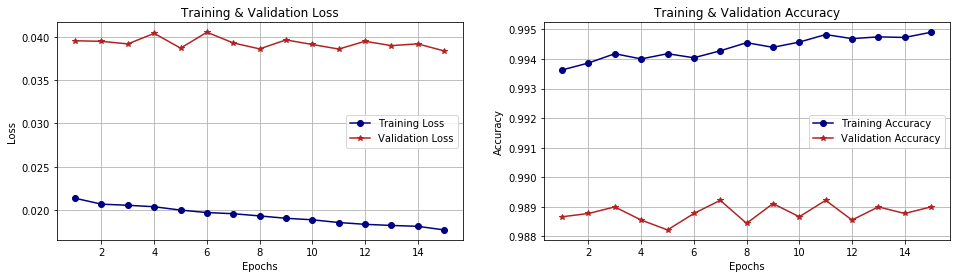

Train on 51000 samples, validate on 9000 samples
Epoch 1/15
51000/51000 [==============================] - 13s 261us/step - loss: 0.0176 - acc: 0.9951 - val_loss: 0.0378 - val_acc: 0.9892
Epoch 2/15
51000/51000 [==============================] - 13s 246us/step - loss: 0.0174 - acc: 0.9951 - val_loss: 0.0394 - val_acc: 0.9890
Epoch 3/15
51000/51000 [==============================] - 13s 246us/step - loss: 0.0172 - acc: 0.9951 - val_loss: 0.0394 - val_acc: 0.9882
Epoch 4/15
51000/51000 [==============================] - 13s 247us/step - loss: 0.0170 - acc: 0.9950 - val_loss: 0.0388 - val_acc: 0.9897
Epoch 5/15
51000/51000 [==============================] - 13s 247us/step - loss: 0.0169 - acc: 0.9953 - val_loss: 0.0390 - val_acc: 0.9884
Epoch 6/15
51000/51000 [==============================] - 13s 249us/step - loss: 0.0168 - acc: 0.9951 - val_loss: 0.0382 - val_acc: 0.9896
Epoch 7/15
51000/51000 [==============================] - 13s 248us/step - loss: 0.0165 - acc: 0.9952 - val_loss: 0.0

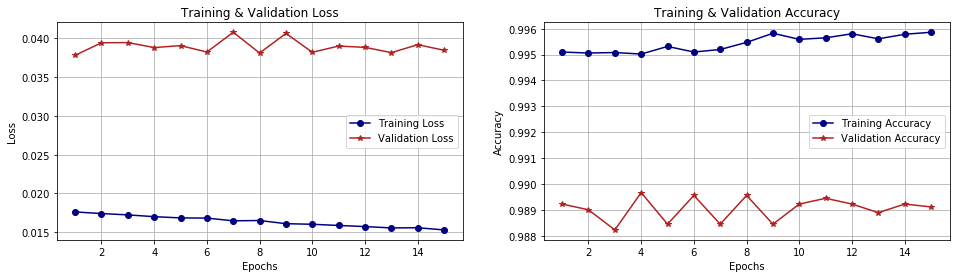

Train on 51000 samples, validate on 9000 samples
Epoch 1/15
51000/51000 [==============================] - 13s 262us/step - loss: 0.0152 - acc: 0.9960 - val_loss: 0.0394 - val_acc: 0.9888
Epoch 2/15
51000/51000 [==============================] - 13s 246us/step - loss: 0.0151 - acc: 0.9960 - val_loss: 0.0385 - val_acc: 0.9893
Epoch 3/15
51000/51000 [==============================] - 13s 246us/step - loss: 0.0151 - acc: 0.9960 - val_loss: 0.0391 - val_acc: 0.9894
Epoch 4/15
51000/51000 [==============================] - 13s 248us/step - loss: 0.0149 - acc: 0.9960 - val_loss: 0.0397 - val_acc: 0.9893
Epoch 5/15
51000/51000 [==============================] - 12s 245us/step - loss: 0.0148 - acc: 0.9961 - val_loss: 0.0389 - val_acc: 0.9894
Epoch 6/15
51000/51000 [==============================] - 12s 245us/step - loss: 0.0145 - acc: 0.9964 - val_loss: 0.0398 - val_acc: 0.9889
Epoch 7/15
51000/51000 [==============================] - 12s 245us/step - loss: 0.0144 - acc: 0.9962 - val_loss: 0.0

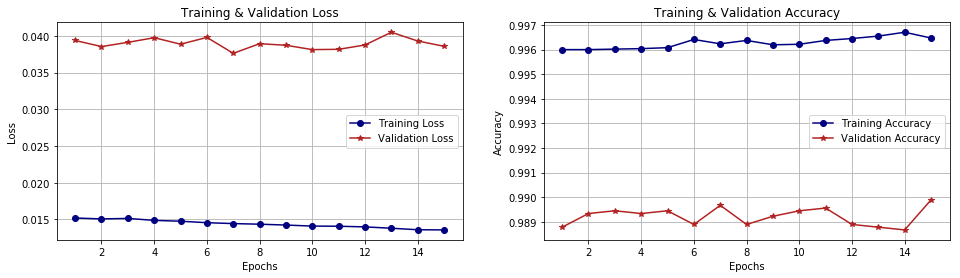

Train on 51000 samples, validate on 9000 samples
Epoch 1/15
51000/51000 [==============================] - 14s 266us/step - loss: 0.0136 - acc: 0.9964 - val_loss: 0.0384 - val_acc: 0.9892
Epoch 2/15
51000/51000 [==============================] - 13s 247us/step - loss: 0.0134 - acc: 0.9966 - val_loss: 0.0396 - val_acc: 0.9890
Epoch 3/15
51000/51000 [==============================] - 13s 246us/step - loss: 0.0133 - acc: 0.9966 - val_loss: 0.0387 - val_acc: 0.9892
Epoch 4/15
51000/51000 [==============================] - 13s 248us/step - loss: 0.0133 - acc: 0.9965 - val_loss: 0.0392 - val_acc: 0.9893
Epoch 5/15
51000/51000 [==============================] - 13s 246us/step - loss: 0.0131 - acc: 0.9968 - val_loss: 0.0387 - val_acc: 0.9894
Epoch 6/15
51000/51000 [==============================] - 13s 247us/step - loss: 0.0131 - acc: 0.9966 - val_loss: 0.0384 - val_acc: 0.9893
Epoch 7/15
51000/51000 [==============================] - 13s 248us/step - loss: 0.0129 - acc: 0.9968 - val_loss: 0.0

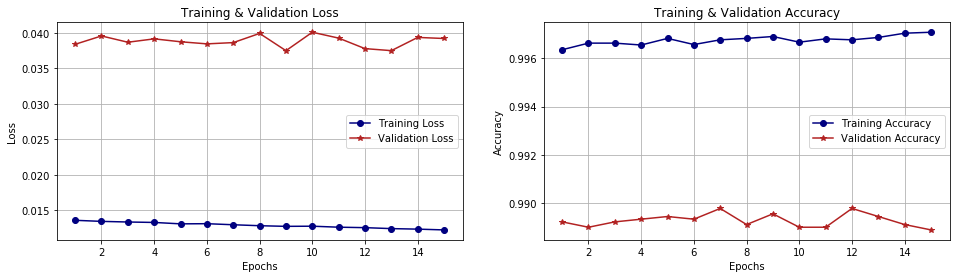

In [59]:
activations = ['tanh','sigmoid','relu', 'softmax']

optimized_activation_plot = create_model_optimized(activations,batch_size)